<a href="https://colab.research.google.com/github/taywiljoe/Project-4/blob/alang/Diabetes_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
import os
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

In [2]:
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,194 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,466 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted a

In [3]:
#Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

In [4]:
# Start a SparkSession
import findspark
findspark.init()


In [5]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

from pyspark.sql import SparkSession
import time



#  Import and read the diabetes_prediction_dataset.csv.
import pandas as pd
url = "https://raw.githubusercontent.com/taywiljoe/Project-4/main/diabetes_prediction_dataset.csv"
diabetes_df = pd.read_csv(url)
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
#application_df.drop(['EIN', 'NAME'], axis=1, inplace=True)



In [7]:
# Determine the number of unique values in each column.
diabetes_df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [8]:
diabetes_df['diabetes'].value_counts()

0    91500
1     8500
Name: diabetes, dtype: int64

In [9]:
recall

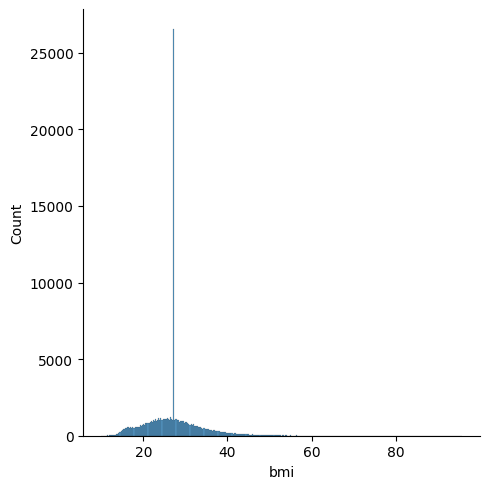

In [10]:
import seaborn as sns
sns.displot(diabetes_df['bmi'])

In [11]:
# Look at bmi value counts for binning
diabetes_df['bmi'].value_counts()


27.32    25495
23.00      103
27.12      101
27.80      100
24.96      100
         ...  
58.23        1
48.18        1
55.57        1
57.07        1
60.52        1
Name: bmi, Length: 4247, dtype: int64

In [12]:
# You may find it helpful to look at CLASSIFICATION value counts >1
#application_df['CLASSIFICATION'].value_counts().gt(1).sum()
#diabetes_df['bmi'].value_counts().loc[lambda x : x<35]


In [13]:
import numpy as np
import math
from sklearn.datasets import load_iris
from sklearn import datasets, linear_model, metrics

In [14]:
# load bmi data
dataset = diabetes_df['bmi']
dataset


0        25.19
1        27.32
2        27.32
3        23.45
4        20.14
         ...  
99995    27.32
99996    17.37
99997    27.83
99998    35.42
99999    22.43
Name: bmi, Length: 100000, dtype: float64

In [15]:
#sort the array
bmi_sort=np.sort(dataset)
bmi_sort

array([10.01, 10.01, 10.08, ..., 91.82, 95.22, 95.69])

In [16]:
# create bins
bin0=[]
bin1=[]
bin2=[]
bin3=[]
bin4=[]
bin5=[]


# loop thru array to load bins
for i in range (100000):
     if bmi_sort[i] <= 15 and bmi_sort[i] >= 0:
          bin0.append(bmi_sort[i])
     elif bmi_sort[i] <= 23 and bmi_sort[i] > 15:
          bin1.append(bmi_sort[i])
     elif bmi_sort[i] <= 29 and bmi_sort[i] > 23:
          bin2.append(bmi_sort[i])
     elif bmi_sort[i] <= 33 and bmi_sort[i] > 29:
          bin3.append(bmi_sort[i])
     elif bmi_sort[i] <= 37 and bmi_sort[i] > 33:
          bin4.append(bmi_sort[i])
     elif bmi_sort[i] > 37:
          bin5.append(bmi_sort[i])
    #elif bmi_sort[i] <= 69 and bmi_sort[i] >= 60:
    #    bin6.append(bmi_sort[i])
    #elif bmi_sort[i] <= 79 and bmi_sort[i] >= 70:
    #    bin7.append(bmi_sort[i])
    #elif bmi_sort[i] <= 89 and bmi_sort[i] >= 80:
    #  bin8.append(bmi_sort[i])
    #elif bmi_sort[i] <= 99 and bmi_sort[i] >= 90:
    #  bin9.append(bmi_sort[i])

# view bin lengths
len(bin0),len(bin1),len(bin2),len(bin3),len(bin4),len(bin5)


(1509, 20984, 50404, 12314, 7047, 7742)

In [17]:
# Bin mean
#for i in range (0,150,5):
#     k=int(i/5)
#     mean=(b[i] + b[i+1] + b[i+2] + b[i+3] + b[i+4])/5
#    for j in range(5):
#      bin1[k,j]=mean
#print("Bin Mean: \n",bin1)

In [18]:
# Bin boundaries
for i in range (0,150,5):
    k=int(i/5)
    for j in range (5):
        if (b[i+j]-b[i]) < (b[i+4]-b[i+j]):
            bin2[k,j]=b[i]
        else:
            bin2[k,j]=b[i+4]
print("Bin Boundaries: \n",bin2)

NameError: ignored

In [19]:
# Choose a cutoff value and create a list of bmi values to be replaced
# use the variable name `bin_types_to_replace`
# Replace bmi values < 14 and > 37 in dataframe
bmi_values_to_replace = bin0

for app in bmi_values_to_replace:
     diabetes_df['bmi'] = diabetes_df['bmi'].replace(app,15.00)

bmi_values_to_replace = bin5

for app in bmi_values_to_replace:
     diabetes_df['bmi'] = diabetes_df['bmi'].replace(app,37.00)

# Check to make sure binning was successful
diabetes_df['bmi'].value_counts()


27.32    25495
37.00     7770
15.00     1509
23.00      103
27.12      101
         ...  
34.62        3
36.48        3
35.76        3
24.49        2
35.16        2
Name: bmi, Length: 2201, dtype: int64

In [20]:
# Convert categorical data to numeric with `pd.get_dummies`
y = diabetes_df['diabetes']
X = diabetes_df.drop(columns='diabetes')
X = pd.get_dummies(X)
X.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,0,1,0,0,0,0


In [21]:
# Import the RandomOverSampler module from imbalanced-learn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_res, y_res = ros.fit_resample(X, y)
# Count the distinct values of the resampled labels data
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 91500, 1: 91500})


In [22]:
# Split our preprocessed data into our features and target arrays
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=1)
X_train.shape


(137250, 15)

In [23]:
X_test.shape


(45750, 15)

In [24]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled

array([[-1.79168244, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [ 1.36876559, -0.42468913,  3.18326762, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [-0.44384431,  2.3546635 , -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       ...,
       [-0.6762302 , -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       [ 1.36876559,  2.3546635 , -0.31414261, ...,  2.52937254,
        -0.76607461, -0.2801949 ],
       [ 1.22933405, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ]])

In [25]:
X_test_scaled

array([[ 0.06740463, -0.42468913,  3.18326762, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [ 0.16035899, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [-1.32691067, -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       ...,
       [ 1.22933405, -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       [-0.53679867, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461,  3.56894433],
       [-1.83815962, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ]])

## Compile, Train and Evaluate the Model

In [26]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)


In [27]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [28]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [29]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [30]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,22420,490
Actual 1,0,22840


Accuracy Score : 0.9892896174863388
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22910
           1       0.98      1.00      0.99     22840

    accuracy                           0.99     45750
   macro avg       0.99      0.99      0.99     45750
weighted avg       0.99      0.99      0.99     45750



In [31]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.3440320195054071, 'HbA1c_level'),
 (0.27583837459418664, 'blood_glucose_level'),
 (0.18212110715659274, 'age'),
 (0.12561087370510104, 'bmi'),
 (0.0259637882140535, 'hypertension'),
 (0.014935363873723025, 'heart_disease'),
 (0.013045863350349306, 'smoking_history_No Info'),
 (0.004786711173533464, 'smoking_history_former'),
 (0.0028575924526781306, 'smoking_history_never'),
 (0.0025450294889950388, 'gender_Male'),
 (0.0023221148169648605, 'gender_Female'),
 (0.0021789758892442634, 'smoking_history_current'),
 (0.0020448685374733896, 'smoking_history_not current'),
 (0.0017103887294604423, 'smoking_history_ever'),
 (6.928512237050239e-06, 'gender_Other')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

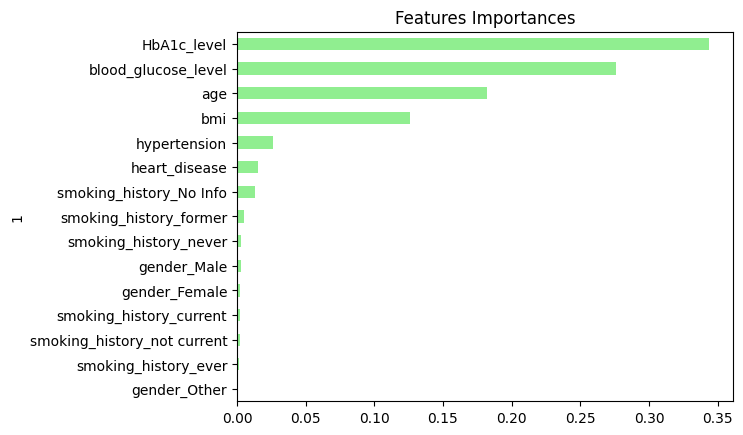

In [32]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [ ]:
# Export our model to HDF5 file
#  YOUR CODE GOES HERE